# Timeseries anomaly detection using an Autoencoder

This script demonstrates how you can use a reconstruction convolutional autoencoder model to detect anomalies in timeseries data.

In [76]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt

# Load the data

We will use the [Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) dataset. It provides artificial
timeseries data containing labeled anomalous periods of behavior. Data are
ordered, timestamped, single-valued metrics.

We will use the `art_daily_small_noise.csv` file for training and the
`art_daily_jumpsup.csv` file for testing. The simplicity of this dataset
allows us to demonstrate anomaly detection effectively.

In [77]:
# Dataset de Train
df_small_noise = pd.read_csv("https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv", 
                             parse_dates=True, index_col="timestamp")
# Dataset de Test
df_daily_jumpsup = pd.read_csv("https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv", 
                               parse_dates=True, index_col="timestamp")

# Visualize the data
## Train Dataet --> Timeseries data without anomalies

We will use the following data for training.

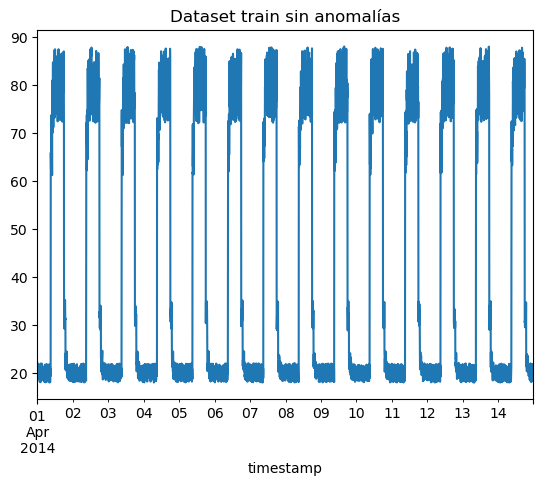

In [78]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax, title='Dataset train sin anomalías')
plt.show()

# Test dataset: --> Timeseries data with anomalies

We will use the following data for testing and see if the sudden jump up in the
data is detected as an anomaly.

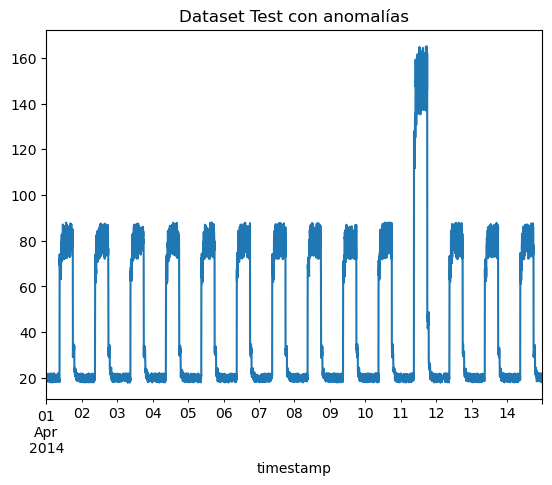

In [79]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax, title='Dataset Test con anomalías')
plt.show()

# Prepare training data

Get data values from the training timeseries data file and normalize the
`value` data. We have a `value` for every 5 mins for 14 days.

-   24 * 60 / 5 = **288 timesteps per day**
-   288 * 14 = **4032 data points** in total

In [80]:
# Normalize and save the mean and std we get, for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


# Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [81]:
TIME_STEPS = 288


# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


# Build a model

We will build a convolutional reconstruction autoencoder model. The model will
take input of shape `(batch_size, sequence_length, num_features)` and return
output of the same shape. In this case, `sequence_length` is 288 and
`num_features` is 1.

## LSTM

In [82]:
model_lstm = keras.Sequential([
    # Capa LSTM de codificación
    layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
    layers.LSTM(64, activation='relu', return_sequences=True),
    layers.Dropout(0.2),
    
    # Capa LSTM adicional para aprender patrones temporales
    layers.LSTM(32, activation='relu', return_sequences=False),
    layers.Dropout(0.2),
    
    # Capa densa para la reconstrucción de la secuencia
    layers.RepeatVector(x_train.shape[1]),
    
    # Capa LSTM de decodificación
    layers.LSTM(32, activation='relu', return_sequences=True),
    layers.LSTM(64, activation='relu', return_sequences=True),
    
    # Capa de salida (devolviendo la secuencia de salida)
    layers.TimeDistributed(layers.Dense(1))
])

model_lstm.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 288, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 288, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 288, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 288, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 288, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 288, 1)         │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,529 (244.25 KB)

 Trainable params: 62,529 (244.25 KB)

 Non-trainable params: 0 (0.00 B)

## CNN

In [83]:
'''
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu",),
        layers.Dropout(rate=0.2),
        layers.Conv1D( filters=16, kernel_size=7, padding="same", strides=2, activation="relu",),
        layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu",),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu",),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=['accuracy'])
model.summary()
'''

'\nmodel = keras.Sequential(\n    [\n        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),\n        layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu",),\n        layers.Dropout(rate=0.2),\n        layers.Conv1D( filters=16, kernel_size=7, padding="same", strides=2, activation="relu",),\n        layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu",),\n        layers.Dropout(rate=0.2),\n        layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu",),\n        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),\n    ]\n)\nmodel.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=[\'accuracy\'])\nmodel.summary()\n'

# Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.

In [84]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="auto")
    ],
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0045 - val_loss: 0.0069
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0045 - val_loss: 0.0066
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0044 - val_loss: 0.0073
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0044 - val_loss: 0.0067
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0044 - val_loss: 0.0066
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0043 - val_loss: 0.0071
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0043 - val_loss: 0.0068


# Validation loss
Let's plot training and validation loss to see how the training went.


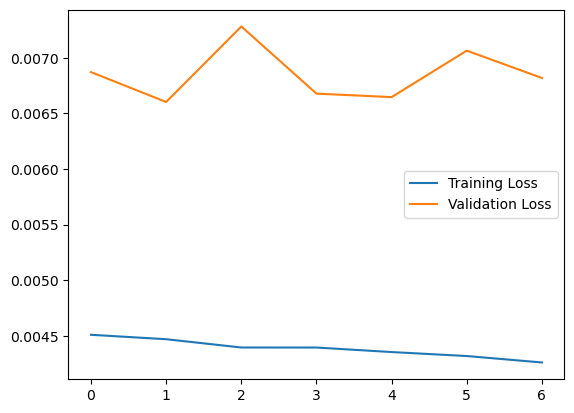

In [85]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

# Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct
the input data.


1.   Find MAE loss on training samples.
2.   Find max MAE loss value. This is the worst our model has performed trying
to reconstruct a sample. We will make this the `threshold` for anomaly
detection.
3.   If the reconstruction loss for a sample is greater than this `threshold`
value then we can infer that the model is seeing a pattern that it isn't
familiar with. We will label this sample as an `anomaly`.


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


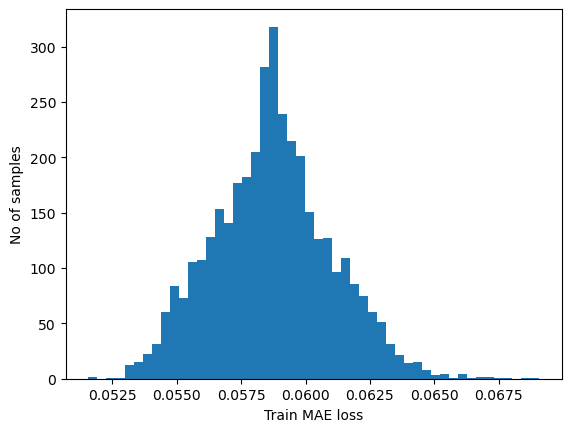

Reconstruction error threshold:  0.0690786628667276


In [86]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

# Compare recontruction

Just for fun, let's see how our model has recontructed the first sample.
This is the 288 timesteps from day 1 of our training dataset.

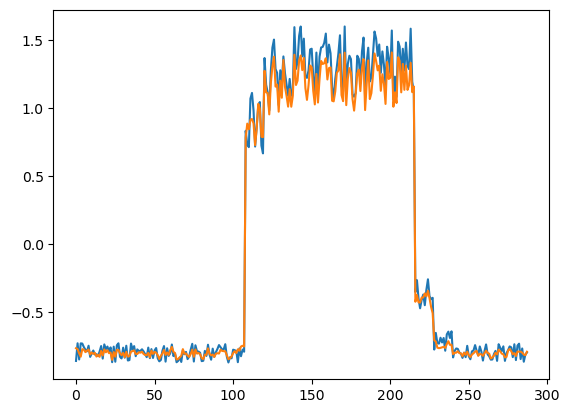

In [87]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

# Prepare test data


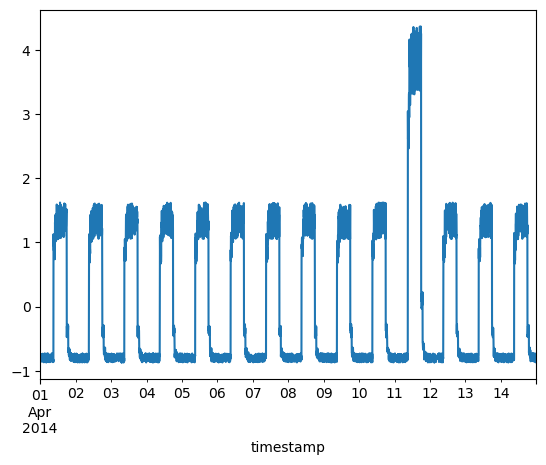

In [88]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.

In [89]:
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

Test input shape:  (3745, 288, 1)


# Get test MAE loss.


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


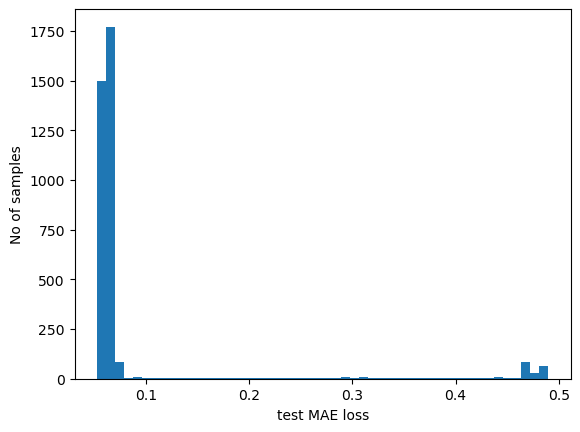

In [90]:
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.

In [91]:
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  549
Indices of anomaly samples:  (array([ 105,  106,  214,  215,  216,  393,  773,  790,  793,  794,  795,
        969,  970,  973, 1369, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
       1950, 1952, 1954, 1958, 2002, 2006, 2008, 2009, 2010, 2012, 2014,
       2015, 2016, 2018, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2028,
       2030, 2034, 2036, 2037, 2038, 2040, 2041, 2042, 2043, 2044, 2045,
       2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056,
       2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067,
       2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078,
       2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089,
       2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100,
       2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111,
       2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122,
       2123, 2125, 2126, 2129, 2130, 2132, 2133, 2137, 2138, 2

# Plot anomalies

We now know the samples of the data which are anomalies. With this, we will
find the corresponding `timestamps` from the original test data. We will be
using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our `x_train` will
look like this:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

All except the initial and the final time_steps-1 data values, will appear in
`time_steps` number of samples. So, if we know that the samples
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point
5 is an anomaly.

In [92]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

Let's overlay the anomalies on the original test data plot.

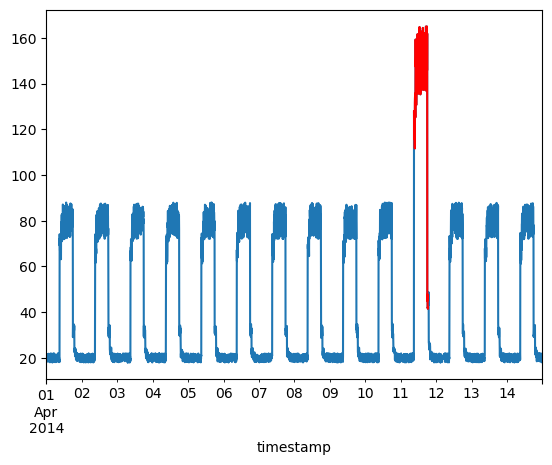

In [93]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()